In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from darts import SeasonalityMode
from darts.models import NaiveSeasonal, NaiveDrift
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, FourTheta
from darts.models import StandardRegressionModel
from darts.utils.statistics import check_seasonality, remove_seasonality, extract_trend_and_seasonality

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import pickle

In [3]:
from M4_metrics import owa_m4, smape_m4, mase_m4

In [4]:
from darts.utils.timeseries_generation import constant_timeseries as ct

In [5]:
import logging
import warnings
warnings.filterwarnings('ignore')
logging.disable(logging.CRITICAL)

In [6]:
download = False
preprocess = False

### Download and create TimeSeries

In [7]:
if download:
    %run -i "download_data_M4.py"
if preprocess:
    %run -i "create_ts.py"

### dataset info

In [8]:
# data_categories = ['Macro', 'Micro', 'Demographic', 'Industry', 'Finance', 'Other']
data_freq = ['Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly']
info_dataset = pd.read_csv('dataset/M4-info.csv', delimiter=',').set_index('M4id')

In [9]:
info_dataset.head()

,category,Frequency,Horizon,SP,StartingDate
M4id,,,,,
Y1,Macro,1,6,Yearly,01-01-79 12:00
Y2,Macro,1,6,Yearly,01-01-79 12:00
Y3,Macro,1,6,Yearly,01-01-79 12:00
Y4,Macro,1,6,Yearly,01-01-79 12:00
Y5,Macro,1,6,Yearly,01-01-79 12:00


In [10]:
info_dataset.filter(regex='W', axis=0).category.unique()

array(['Other', 'Macro', 'Industry', 'Finance', 'Demographic', 'Micro'],
      dtype=object)

In [11]:
info_dataset.groupby('SP').count()

,category,Frequency,Horizon,StartingDate
SP,,,,
Daily,4227,4227,4227,4227
Hourly,414,414,414,414
Monthly,48000,48000,48000,48000
Quarterly,24000,24000,24000,24000
Weekly,359,359,359,359
Yearly,23000,23000,23000,23000


In [12]:
print(info_dataset.groupby('SP').Frequency.unique())
print(info_dataset.groupby('SP').Horizon.unique())

SP
Daily         [1]
Hourly       [24]
Monthly      [12]
Quarterly     [4]
Weekly        [1]
Yearly        [1]
Name: Frequency, dtype: object
SP
Daily        [14]
Hourly       [48]
Monthly      [18]
Quarterly     [8]
Weekly       [13]
Yearly        [6]
Name: Horizon, dtype: object


### evaluating methods 

In [13]:
freq = 'Hourly'
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))

In [14]:
mase_all = []
smape_all = []
m = int(info_dataset.Frequency[freq[0]+'1'])
for train, test in tqdm(zip(ts_train, ts_test)):
    # remove seasonality
    train_des=train
    seasonOut = ct(length=len(test), freq=train.freq_str(), start_ts=test.start_time())
    season = ct(length=len(train), freq=train.freq_str(), start_ts=train.start_time())
    if m > 1:
        if check_seasonality(train, m=m, max_lag=2*m):
            _, season = extract_trend_and_seasonality(train, m, model=SeasonalityMode.MULTIPLICATIVE)
            train_des = remove_seasonality(train, freq=m, model=SeasonalityMode.MULTIPLICATIVE)
            seasonOut = season[-m:].shift(m)
            seasonOut = seasonOut.append_values(seasonOut.values())[:len(test)]
    # model selection
    naiveSeason = NaiveSeasonal(K=m)
    naive2 = NaiveSeasonal(K=1)
    ses = ExponentialSmoothing(trend=None, seasonal=None)
    holt = ExponentialSmoothing(seasonal=None, damped=False, trend='additive')
    damp = ExponentialSmoothing(seasonal=None, damped=True, trend='additive')
    fourtheta = FourTheta.select_best_model(train, thetas=[1,2,3], m=m)
    # model fitting
    naiveSeason.fit(train)
    naive2.fit(train_des)
    fourtheta.fit(train)
    ses.fit(train_des)
    holt.fit(train_des)
    damp.fit(train_des)
    # forecasting
    forecast_naiveSeason = naiveSeason.predict(len(test))
    forecast_naive2 = naive2.predict(len(test)) * seasonOut
    forecast_fourtheta = fourtheta.predict(len(test))
    forecast_ses = ses.predict(len(test))*seasonOut
    forecast_holt = holt.predict(len(test))*seasonOut
    forecast_damp = damp.predict(len(test))*seasonOut
    # baseline constant weight ensembling
    forecast_comb = ((forecast_ses + forecast_holt + forecast_damp) / 3)
    
    mase_all.append(np.vstack([
                               mase_m4(train, test, forecast_naiveSeason, m=m),
                               mase_m4(train, test, forecast_naive2, m=m),
                               mase_m4(train, test, forecast_fourtheta, m=m),
                               mase_m4(train, test, forecast_ses, m=m),
                               mase_m4(train, test, forecast_holt, m=m),
                               mase_m4(train, test, forecast_damp, m=m),
                               mase_m4(train, test, forecast_comb, m=m),
                              ]))
    smape_all.append(np.vstack([
                                smape_m4(test, forecast_naiveSeason),
                                smape_m4(test, forecast_naive2),
                                smape_m4(test, forecast_fourtheta),
                                smape_m4(test, forecast_ses),
                                smape_m4(test, forecast_holt),
                                smape_m4(test, forecast_damp),
                                smape_m4(test, forecast_comb),
                               ]))

In [15]:
print("MASE; naiveSeason: {:.3f}, naive2: {:.3f}, 4Theta: {:.3f},\n"
       "SES: {:.3f}, Holt: {:.3f}, Damp: {:.3f}, Comb: {:.3f}\n".format(*tuple(np.stack(mase_all).mean(axis=(0,2)))))
print("sMAPE; naiveSeason: {:.3f}, naive2: {:.3f}, 4Theta: {:.3f},\n"
       "SES: {:.3f}, Holt: {:.3f}, Damp: {:.3f}, Comb: {:.3f}\n".format(*tuple(np.stack(smape_all).mean(axis=(0,2)))))
print("OWA; naiveSeason: {:.3f}, naive2: {:.3f}, 4Theta: {:.3f},\n"
       "SES: {:.3f}, Holt: {:.3f}, Damp: {:.3f}, Comb: {:.3f}\n".format(*tuple(owa_m4(freq, 
                                                                        np.stack(smape_all).mean(axis=(0,2)), 
                                                                        np.stack(mase_all).mean(axis=(0,2))))))

MASE; naiveSeason: 1.193, naive2: 2.400, 4Theta: 1.768,
SES: 2.373, Holt: 8.728, Damp: 2.938, Comb: 4.237

sMAPE; naiveSeason: 13.912, naive2: 18.820, 4Theta: 17.510,
SES: 18.216, Holt: 27.997, Damp: 19.194, Comb: 21.475

OWA; naiveSeason: 0.628, naive2: 1.013, 4Theta: 0.845,
SES: 0.991, Holt: 2.584, Damp: 1.135, Comb: 1.469



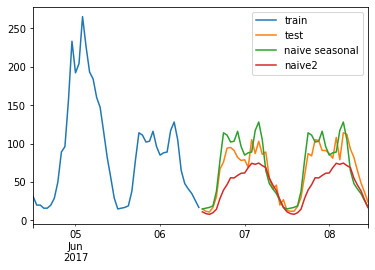

In [16]:
train[-2*m:].plot(label='train')
test.plot(label='test')
forecast_naiveSeason.plot(label='naive seasonal')
forecast_naive2.plot(label='naive2')
plt.legend()

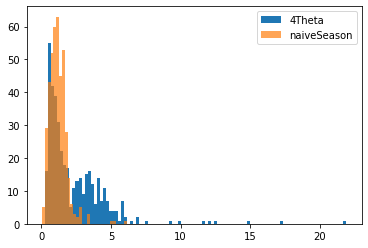

In [17]:
plt.hist(np.nanmean(np.stack(mase_all), axis=(2,))[:,3], bins=100, label='4Theta')
plt.hist(np.nanmean(np.stack(mase_all), axis=(2,))[:,0], bins=30, label='naiveSeason', alpha=0.7)
plt.legend();

Visualization

In [18]:
freq = 'Monthly'
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))

In [19]:
_id = 1
train = ts_train[_id]
test = ts_test[_id]

In [20]:
m = int(info_dataset.Frequency[freq[0]+'1'])
train_des=train
seasonOut = ct(length=len(test), freq=train.freq_str(), start_ts=test.start_time())
season = ct(length=len(train), freq=train.freq_str(), start_ts=train.start_time())
if m > 1:
    if check_seasonality(train, m=int(m), max_lag=2*m):
        _, season = extract_trend_and_seasonality(train, m, model=SeasonalityMode.MULTIPLICATIVE)
        train_des = remove_seasonality(train, freq=m, model=SeasonalityMode.MULTIPLICATIVE)
        seasonOut = season[-m:].shift(m)
        seasonOut = seasonOut.append_values(seasonOut.values())[:len(test)]
    else:
        m = 1
# model selection
naiveSeason = NaiveSeasonal(K=m)
naive2 = NaiveSeasonal(K=1)
prophet = Prophet(yearly_seasonality=True, changepoint_range=0.95)
arima = AutoARIMA()
fourtheta = FourTheta.select_best_model(train, thetas=[1, 2, 3], m=m)
# model fitting
naiveSeason.fit(train)
naive2.fit(train_des)
fourtheta.fit(train)
prophet.fit(train)
arima.fit(train)
# forecasting
forecast_naiveSeason = naiveSeason.predict(len(test))
forecast_naive2 = naive2.predict(len(test)) * seasonOut
forecast_fourtheta = fourtheta.predict(len(test))
forecast_arima = arima.predict(len(test))
forecast_prophet = prophet.predict(len(test))

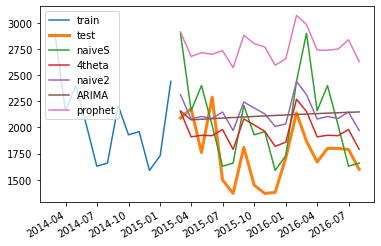

In [21]:
train[-m:].plot(label='train')
test.plot(label='test', lw=3)
forecast_naiveSeason.plot(label='naiveS')
forecast_fourtheta.plot(label='4theta')
forecast_naive2.plot(label='naive2')
forecast_arima.plot(label='ARIMA')
forecast_prophet.pd_series().plot(label='prophet')
plt.legend()

#### 4Theta

4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.MULTIPLICATIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)
Theta MASE: 1.594
4Theta MASE: 1.485


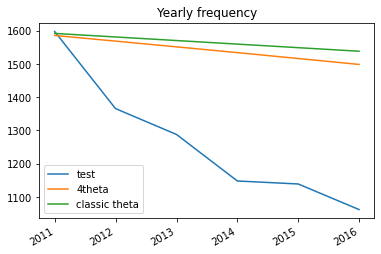

In [22]:
freq = 'Yearly'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 1
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.MULTIPLICATIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)
Theta MASE: 1.373
4Theta MASE: 1.501


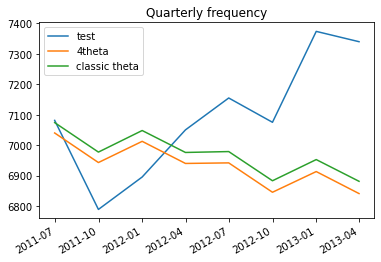

In [23]:
freq = 'Quarterly'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 1
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

4Theta(theta:2, curve:TrendMode.EXPONENTIAL, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.ADDITIVE)
Theta MASE: 1.053
4Theta MASE: 0.992


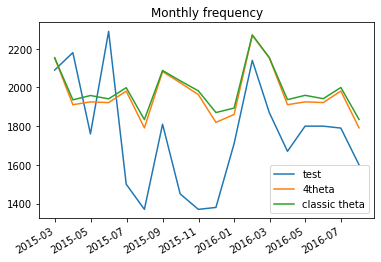

In [24]:
freq = 'Monthly'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 1
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

4Theta(theta:2, curve:TrendMode.EXPONENTIAL, model:ModelMode.MULTIPLICATIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)
Theta MASE: 10.147
4Theta MASE: 9.599


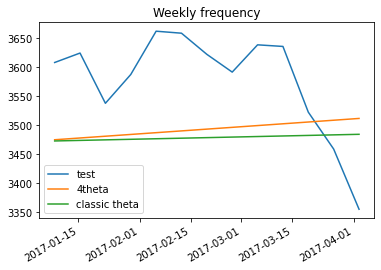

In [25]:
freq = 'Weekly'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 1
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)
Theta MASE: 2.055
4Theta MASE: 2.049


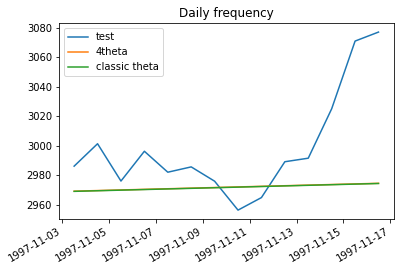

In [26]:
freq = 'Daily'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 1
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

4Theta(theta:2, curve:TrendMode.EXPONENTIAL, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE)
Theta MASE: 0.649
4Theta MASE: 0.646


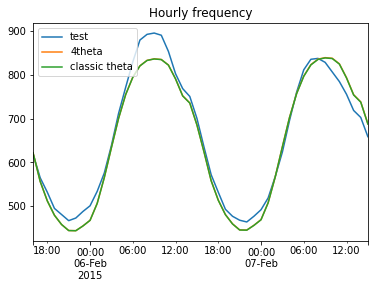

In [27]:
freq = 'Hourly'
m = int(info_dataset.Frequency[freq[0]+'1'])
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 0
train = ts_train[_id]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=[2], m=m)
theta = Theta(seasonality_period=m)
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

Now, let's try to find a better theta, and a better frequency

4Theta(theta:10.0, curve:TrendMode.EXPONENTIAL, model:ModelMode.MULTIPLICATIVE, seasonality:SeasonalityMode.ADDITIVE)
Theta MASE: 1.649
4Theta MASE: 1.074


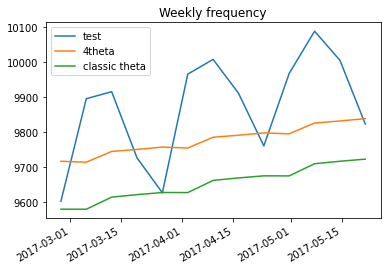

In [28]:
freq = 'Weekly'
plt.figure()
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))
_id = 2
train = ts_train[_id][-100:]
test = ts_test[_id]
fourtheta = FourTheta.select_best_model(train, thetas=np.linspace(-1, 10, 90), m=None)
theta = Theta(theta=(2 - fourtheta.theta))
print(fourtheta)

fourtheta.fit(train)
theta.fit(train)

forecast_fourtheta = fourtheta.predict(len(test))
forecast_theta = theta.predict(len(test))

test.plot(label='test')
forecast_fourtheta.plot(label='4theta')
forecast_theta.plot(label='classic theta')
plt.title(freq + ' frequency')
print("Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_theta))))
print("4Theta MASE: {:.3f}".format(np.mean(mase_m4(train, test, forecast_fourtheta))))
plt.legend();

#### run evaluation

In [29]:
run_baseline = False
if run_baseline:
    %run -i "evaluate_baselines.py"

In [30]:
run_thetas = False
if run_thetas:
    %run -i "evaluate_theta_methods.py"

In [31]:
run_fft = False
if run_fft:
    %run -i "evaluate_fft.py"

In [32]:
run_arima = False
if run_arima:
    %run -i "evaluate_arima.py"

In [33]:
run_prophet = False
if run_prophet:
    %run -i "evaluate_prophet.py"

#### Ensembling

In [34]:
from sklearn.linear_model import LassoCV

In [35]:
from evaluate_ensembling import naive2_groe, groe_owa, DeseasonForecastingModel
deseason_model = DeseasonForecastingModel

In [37]:
freq = 'Monthly'
ts_train = pickle.load(open("dataset/train_"+freq+".pkl", "rb"))
ts_test = pickle.load(open("dataset/test_"+freq+".pkl", "rb"))

mase_all = []
smape_all = []
m = int(info_dataset.Frequency[freq[0]+'1'])
for train, test in tqdm(zip(ts_train[:5], ts_test[:5])):
    # remove seasonality
    train_des=train
    seasonOut = 1
    season = ct(length=len(train), freq=train.freq_str(), start_ts=train.start_time())
    if m > 1:
        if check_seasonality(train, m=int(m), max_lag=2*m):
            pass
            _, season = extract_trend_and_seasonality(train, m, model=SeasonalityMode.MULTIPLICATIVE)
            train_des = remove_seasonality(train, freq=m, model=SeasonalityMode.MULTIPLICATIVE)
            seasonOut = season[-m:].shift(m)
            seasonOut = seasonOut.append_values(seasonOut.values())[:len(test)]
    # model choice
    naiveSeason = NaiveSeasonal(K=m)
    naiveDrift = NaiveDrift()
    naive2 = NaiveSeasonal(K=1)
    ses = ExponentialSmoothing(trend=None, seasonal=None, seasonal_periods=m)
    holt = ExponentialSmoothing(seasonal=None, damped=False, trend='additive', seasonal_periods=m)
    damp = ExponentialSmoothing(seasonal=None, damped=True, trend='additive', seasonal_periods=m)
    # prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    
    fourtheta = FourTheta.select_best_model(train, thetas=[1, 2, 3], m=m)
    theta = Theta(theta=2, season_mode=SeasonalityMode.MULTIPLICATIVE, seasonality_period=m)
    models_simple = [naiveSeason, theta, fourtheta]
    models_des = [naive2, ses, holt, damp]

    # linear regression (with constraints)
    def train_pred(id_start=None, id_end=None):
        for m in models_simple:
            m.fit(train[id_start:id_end])
        for m in models_des:
            m.fit(train_des[id_start:id_end])
        models_simple_predictions = [m.predict(len(test))
                                     for m in models_simple]
        id_fin = id_end+len(test)
        if id_fin == 0:
            id_fin = None
        models_des_predictions = [m.predict(len(test)) * (seasonOut if id_end is None else season[id_end:id_fin])
                                  for m in models_des]

        model_predictions = models_simple_predictions + models_des_predictions
        
        return model_predictions
    
    val_predictions = train_pred(id_end=-len(test))

    regr_model = StandardRegressionModel(train_n_points=len(test), 
                                         model=LassoCV(positive=True, fit_intercept=False, max_iter=5000))
    target_val = train.slice_intersect(val_predictions[0])
    regr_model.fit(val_predictions, target_val)
    bktest_pred = val_predictions
    
    for mod in models_simple:
        mod.fit(train)
    for mod in models_des:
        mod.fit(train_des)
    
    models_simple_predictions = [mod.predict(len(test))
                                 for mod in models_simple]
    models_des_predictions = [mod.predict(len(test)) * seasonOut
                              for mod in models_des]

    model_predictions = models_simple_predictions + models_des_predictions
    
    regr_model.model.coef_ = regr_model.model.coef_/np.sum(regr_model.model.coef_)
    
    ensemble_pred = regr_model.predict(model_predictions)
    
    # Mean ensembling
    mean_pred = 0
    for pred in model_predictions:
        mean_pred = pred + mean_pred
    mean_pred = mean_pred/len(model_predictions)
    
    ## GROE OWA
    criterion = []
    criterion.append(groe_owa(train, naiveSeason, max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, theta, max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, fourtheta, max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, deseason_model(NaiveSeasonal(K=1), m), max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, deseason_model(ses, m), max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, deseason_model(holt, m), max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    criterion.append(groe_owa(train, deseason_model(damp, m), max(5, len(train)-len(test)), int(np.floor(len(test)/6)), 6, m))
    
    Score = 1/np.array(criterion)
    pesos = Score/Score.sum()
    
    groe_ensemble = 0
    for prediction, weight in zip(model_predictions, pesos):
        groe_ensemble = prediction * weight + groe_ensemble
    
    # BO3 ensembling
    score = np.argsort(Score)[::-1][:3]
    pesos2 = Score[score]/Score[score].sum()
    
    bo3_ensemble = 0
    bo3_mean = 0
    for i, model in enumerate(score):
            bo3_ensemble = model_predictions[model]*pesos2[i] + bo3_ensemble
            bo3_mean = model_predictions[model]/len(score) + bo3_mean
    
    mase_all.append(np.vstack([
                               mase_m4(train, test, models_des_predictions[0], m=m),
                               mase_m4(train, test, ensemble_pred, m=m),
                               mase_m4(train, test, mean_pred, m=m),
                               mase_m4(train, test, groe_ensemble, m=m),
                               mase_m4(train, test, bo3_ensemble, m=m),
                               mase_m4(train, test, bo3_mean, m=m),
                              ]))
    smape_all.append(np.vstack([
                                smape_m4(test, models_des_predictions[0]),
                                smape_m4(test, ensemble_pred),
                                smape_m4(test, mean_pred),
                                smape_m4(test, groe_ensemble),
                                smape_m4(test, bo3_ensemble),
                                smape_m4(test, bo3_mean),
                               ]))

In [38]:
print("MASE; Naive2: {:.3f}, Linear Regression: {:.3f}, Mean ensembling: {:.3f}, GROE ensembling: {:.3f}, "
      "BO3 ensembling: {:.3f}, BO3 Mean: {:.3f}".format(*tuple(np.nanmean(np.stack(mase_all), axis=(0, 2)))))
print("sMAPE; Naive2: {:.3f}, Linear Regression: {:.3f}, Mean ensembling: {:.3f}, GROE ensembling: {:.3f}, "
      "BO3 ensembling: {:.3f}, BO3 Mean: {:.3f}".format(*tuple(np.nanmean(np.stack(smape_all), axis=(0, 2)))))

MASE; Naive2: 1.098, Linear Regression: 1.068, Mean ensembling: 0.966, GROE ensembling: 0.973, BO3 ensembling: 1.003, BO3 Mean: 0.994
sMAPE; Naive2: 8.974, Linear Regression: 8.678, Mean ensembling: 7.705, GROE ensembling: 7.830, BO3 ensembling: 8.160, BO3 Mean: 8.026


In [39]:
print("OWA: ", owa_m4(freq,
                      np.nanmean(np.stack(mase_all), axis=(0, 2)),
                      np.nanmean(np.stack(smape_all), axis=(0, 2))))

OWA:  [4.25921273 4.11861286 3.65788532 3.71683597 3.87316115 3.80968261]


#### Visualization

Linear Regression (Lasso)

Text(0.5, 1.0, 'Validation MASE = 0.432')

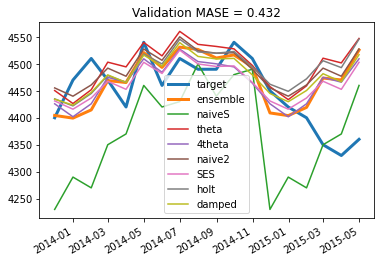

In [40]:
labels = ['naiveS', 'theta', '4theta', 'naive2','SES', 'holt', 'damped']
target_val.plot(label="target", lw=3)
pred = regr_model.predict(bktest_pred)
pred.plot(label="ensemble", lw=3)
for i, mod in enumerate(bktest_pred):
    mod.plot(label=labels[i])
plt.legend()
plt.title("Validation MASE = {:.3f}".format(np.mean(mase_m4(train[:-len(test)], train[-len(test):], pred, m=m))))

In [41]:
regr_model.model.coef_

array([0.21215518, 0.63937082, 0.00330463, 0.14516937, 0.        ,
       0.        , 0.        ])

Text(0.5, 1.0, 'Test MASE = 0.421')

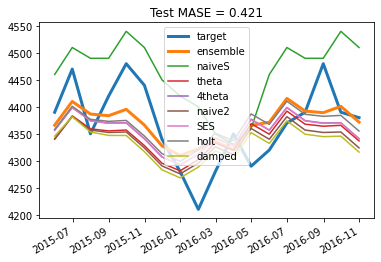

In [42]:
labels = ['naiveS', 'theta', '4theta', 'naive2','SES', 'holt', 'damped']
test.plot(label="target", lw=3)
ensemble_pred.plot(label="ensemble", lw=3)
for i,mod in enumerate(model_predictions):
    mod.plot(label=labels[i])
plt.legend()
plt.title("Test MASE = {:.3f}".format(np.mean(mase_m4(train, test, ensemble_pred, m=m))))

GROE and other Ensembling

Text(0.5, 1.0, 'MASE mean = 0.430, GROE = 0.496')

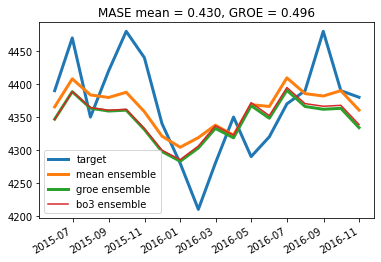

In [43]:
test.plot(label="target", lw=3)
mean_pred.plot(label='mean ensemble', lw=3)
groe_ensemble.plot(label="groe ensemble", lw=3)
bo3_mean.plot(label="bo3 ensemble")
plt.legend()
plt.title("MASE mean = {:.3f}, GROE = {:.3f}".format(np.mean(mase_m4(train, test, mean_pred, m=m)), 
                                                     np.mean(mase_m4(train, test, groe_ensemble, m=m))))

In [44]:
# GROE weights
pesos

array([0.00705447, 0.14044403, 0.05853393, 0.43958416, 0.05530406,
       0.18642169, 0.11265765])